In [30]:
import re
import pickle
import numpy as np
import pandas as pd
from nltk.util import ngrams
from nltk import word_tokenize
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import itertools
from prettytable import PrettyTable
from nltk.stem import WordNetLemmatizer 
from IPython.display import clear_output
import os

#set working directory
os.chdir('../qanon_data/')

# Setup

### Read the files

In [2]:
subs = pd.read_csv("qanon_subs.csv", index_col=0)
coms = pd.read_csv("qanon_coms.csv", index_col=0)
hsd = pd.read_csv("hsd.csv")
egl = pd.read_csv("egl.csv")

In [3]:
with open("psubs.pickle", "rb") as fp:   # Unpickling
    psubs = pickle.load(fp)

with open("pcoms.pickle", "rb") as fp:   # Unpickling
    pcoms = pickle.load(fp)

with open("pegl.pickle", "rb") as fp:   # Unpickling
    pegl = pickle.load(fp)

with open("phsd.pickle", "rb") as fp:   # Unpickling
    phsd = pickle.load(fp)

In [4]:
subs.head()

,author,subreddit,created_utc,post_id,title,selftext,score,text
0,-4D-,CBTS_Stream,2017-12-20 00:24:12,7kzb51,Hello all,This is so new to me Reddit never used befor...,9,Hello all This is so new to me Reddit never u...
1,-4D-,CBTS_Stream,2017-12-20 03:26:25,7l042s,Crypto,Is it safe to say that crypto currencies are ...,1,Crypto Is it safe to say that crypto currencie...
2,-4D-,CBTS_Stream,2018-01-04 10:38:59,7o3ql8,Note Treys words. He mentioned seeing the evid...,,225,Note Treys words. He mentioned seeing the evid...
3,-4D-,CBTS_Stream,2018-01-04 18:57:54,7o71u3,We ask who Q is. Have I just stumbled on what ...,Hi to all my fellow truthers out there. I hav...,44,We ask who Q is. Have I just stumbled on what ...
4,-4D-,CBTS_Stream,2018-01-10 10:59:46,7pghf7,Is this where we will see POTUS make a move to...,,4,Is this where we will see POTUS make a move to...


In [5]:
coms.head()

,author,subreddit,created_utc,post_id,parent_comment_id,associated_sub_id,score,text
0,--FaceMan--,CBTS_Stream,2018-02-21 15:32:59,dum5tjq,t3_7z2158,7z2158,1,WHAT SHOULD WE BE DOING ABOUT IT THEN....WHAT...
1,--FaceMan--,CBTS_Stream,2018-02-21 16:12:49,dum8i8u,t3_7z2158,7z2158,1,Q POSTS ARE HARMFUL TO DEEP STATE....NOT AT A...
2,--recursive,CBTS_Stream,2018-02-13 20:05:44,du7lj8v,t3_7xe1n0,7xe1n0,-3,&gt;This is what we are fighting. So you re ...
3,--recursive,CBTS_Stream,2018-02-14 17:35:47,du9agqj,t3_7xe1n0,7xe1n0,1,&gt;They re not old and they re NOT people. ...
4,-4D-,CBTS_Stream,2017-12-20 04:10:57,drii76e,t3_7kzz9k,7kzz9k,1,................. What the....... talk about ...


In [6]:
pegl[:3]

[['_ASHKENAZI_', 'direct'],
 ['_ASHKENAZI_', 'direct'],
 ['_CRYPTOKIKE_', 'direct']]

In [54]:
len(subs) + len(coms)

1261267

# Q1. Frequency of top explicit antisemitic terms

Note: explicit comes form the expert generated list with label "direct" and anti-semitic comes from the hate speech dictionary with type "anti-semitic"

In [7]:
#create a set for fast look-up and avoid dubplicates
explicit_antisemitic_terms = set()

for i in range(len(pegl)):
    if pegl[i][1] == "direct":
        explicit_antisemitic_terms.add(pegl[i][0])
        
for i in range(len(phsd)):
    if phsd[i][1] == "anti_semitic":
        explicit_antisemitic_terms.add(phsd[i][0])

In [8]:
#Term Frequency = count all the appearences of the term, and I mean all of them
#Document Frequency = count in how many documents a term appears in, here the term is counted only once in a doucment

def tfdf(textLists, tf, df, terms):
    for text in textLists: #for each post 
        #determine the term frequency
        for chunk in text:
            if chunk in terms :
                tf[chunk] = tf.get(chunk, 0) + 1

        #determine the document frequency
        chunkSet = set(text) #remove duplicates
        for chunk in chunkSet: #for eachcheck 
            if chunk in terms: #check if chunk is a chunk we are interested in
                df[chunk] = df.get(chunk, 0) + 1
                
    return (tf, df)

In [9]:
tf = {}
df = {}
tf, df = tfdf(psubs, tf, df, explicit_antisemitic_terms)
tf, df = tfdf(pcoms, tf, df, explicit_antisemitic_terms)

In [10]:
explicit_antisemitic_df = pd.DataFrame({
    "term" : tf.keys(),
    "freq": tf.values(),
    "doc_freq": df.values()
})
explicit_antisemitic_df.to_csv("Explicit AntiSemitic Counts TFDFcsv", sep=",")
explicit_antisemitic_df.head()  

,term,freq,doc_freq
0,_ZIONIST_,2232,1607
1,_JEW_,5873,3414
2,_ASHKENAZI_,233,2081
3,_JEWISH_,2990,150
4,_HEBREW_,1254,778


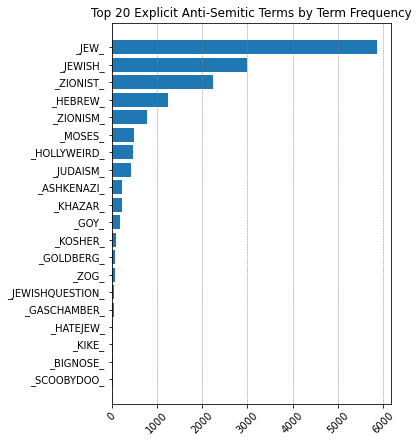

In [12]:
#sort the table by term frequency
explicit_antisemitic_df.sort_values(by=["freq"], ascending=True, inplace=True)

top_terms = explicit_antisemitic_df.tail(20) # get top 15 terms
words = top_terms['term'] # get the terms
values = top_terms['freq'] # get count seperately

fig = plt.figure(figsize=(5, 7))  # Set the figure size to 8x6 inches
ax = fig.subplots()

# Create the bar chart
ax.barh(words, values)

# Set the x-tick positions and labels
maxValue = max(values) + 1001
ax.set_xticks(np.arange(0, maxValue, 1000))
ticks = [str(i) for i in range(0, maxValue, 1000)]
ax.set_xticklabels(ticks, rotation=45)

# Display major grid lines
ax.grid(axis='x', which='major', color='gray', linestyle='--', linewidth=0.5)
plt.title("Top 20 Explicit Anti-Semitic Terms by Term Frequency")
# Show the plot
plt.show()

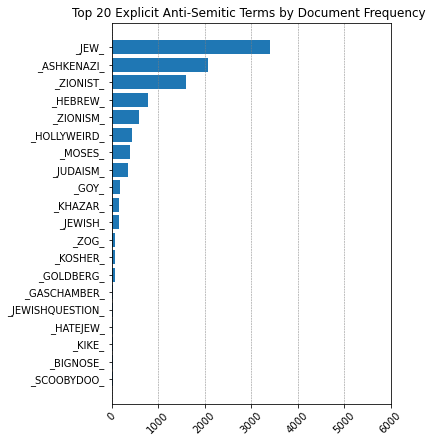

In [13]:
#sort the table by doc freq
explicit_antisemitic_df.sort_values(by=["doc_freq"], ascending=True, inplace=True)

top_terms = explicit_antisemitic_df.tail(20) # get first 15
words = top_terms['term'] # get the terms
values = top_terms['doc_freq'] # get count seperately

fig = plt.figure(figsize=(5, 7))  # Set the figure size to 8x6 inches
ax = fig.subplots()

# Create the bar chart
ax.barh(words, values)

# Set the x-tick positions and labels
ax.set_xticks(np.arange(0, maxValue, 1000))
ax.set_xticklabels(ticks, rotation=45)

# Display major grid lines
ax.grid(axis='x', which='major', color='gray', linestyle='--', linewidth=0.5)
plt.title("Top 20 Explicit Anti-Semitic Terms by Document Frequency ")
# Show the plot
plt.show()

# 2. Propotions of submissions, comments and combined that include explicit-antisemitic language

In [14]:
def proportions(textLists, terms, count = 0):
    for text in textLists: #for each post 

        #determine the document frequency
        chunkSet = set(text)
        for chunk in chunkSet:
            if chunk in terms :#once a post/comment has an explicit anti-semitic term
                count += 1 #flag it 
                break #and stop
                
    return count

In [15]:
print("Proprotion of explicit, anti-semitic language in:\n")

subs_prop = (proportions(psubs, explicit_antisemitic_terms) / len(psubs)) * 100
print("Submissions: " + str(round(subs_prop, 2)) + "%")

coms_prop = (proportions(pcoms, explicit_antisemitic_terms) / len(pcoms)) * 100
print("Comments: " + str(round(coms_prop, 2)) + "%")

combined_prop = (proportions(psubs + pcoms, explicit_antisemitic_terms) / len(psubs + pcoms)) * 100
print("Combined: " + str(round(combined_prop, 2)) + "%")

Proprotion of explicit, anti-semitic language in:

Submissions: 0.56%
Comments: 0.67%
Combined: 0.66%


# 3. Top implicit anti-semitic terms

Note: implicit anti-semitic terms are terms in the expert generate list that are labeled as "indirect", "holocauset" or "israel"

In [16]:
implicit_antisemitic_terms = set()

for i in range(len(pegl)):
    if pegl[i][1] in ["indirect", "holocaust", "israel"]:
        implicit_antisemitic_terms.add(pegl[i][0])

In [17]:
tf = {}
df = {}

tf, df = tfdf(psubs, tf, df, implicit_antisemitic_terms)
tf, df = tfdf(pcoms, tf, df, implicit_antisemitic_terms)

In [18]:
implicit_antisemitic_df = pd.DataFrame({
    "term" : tf.keys(),
    "freq": tf.values(),
    "doc_freq": df.values()
})
implicit_antisemitic_df.to_csv("Implicit Antisemitic Count TFDF.csv", sep=',')
implicit_antisemitic_df.head() 

,term,freq,doc_freq
0,_MOSSAD_,1319,1037
1,_DEEPSTATE_,22577,18035
2,_GLOBALIST_,11403,9153
3,_ILLUMINATI_,3686,524
4,_BILDERBERGS_,662,2834


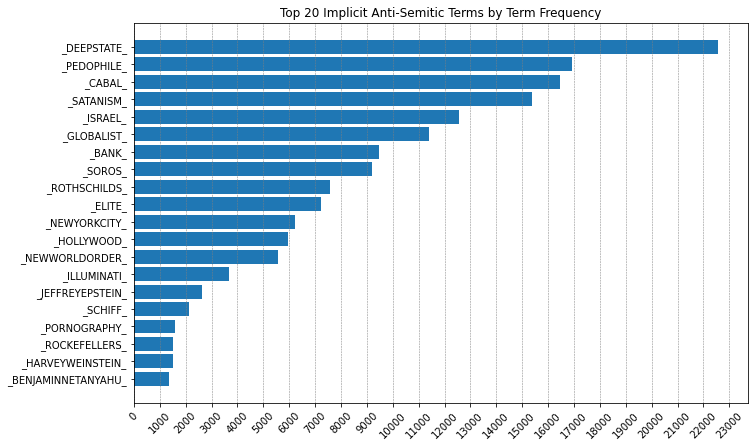

In [19]:
implicit_antisemitic_df.sort_values(by=["freq"], ascending=True, inplace=True)

top_terms = implicit_antisemitic_df.tail(20) # get first 15
words = top_terms['term'] # get the terms
values = top_terms['freq'] # get count seperately

fig = plt.figure(figsize=(11, 7))  # Set the figure size to 8x6 inches
ax = fig.subplots()

# Create the bar chart
ax.barh(words, values)

# Set the x-tick positions and labels
maxValue = max(values) + 1001
ax.set_xticks(np.arange(0, maxValue, 1000))
ticks = [str(i) for i in range(0, maxValue, 1000)]
ax.set_xticklabels(ticks, rotation=45)

# Display major grid lines
ax.grid(axis='x', which='major', color='gray', linestyle='--', linewidth=0.5)
plt.title("Top 20 Implicit Anti-Semitic Terms by Term Frequency")
# Show the plot
plt.show()

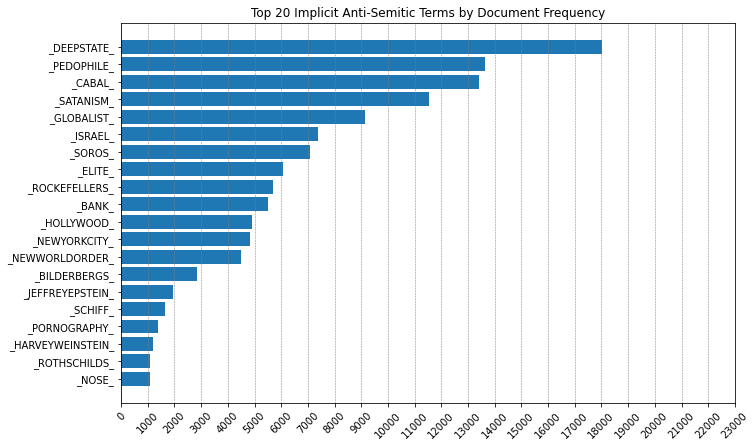

In [20]:
implicit_antisemitic_df.sort_values(by=["doc_freq"], ascending=True, inplace=True)
top_terms = implicit_antisemitic_df.tail(20) # get first 15
words = top_terms['term'] # get the terms
values = top_terms['doc_freq'] # get count seperately

fig = plt.figure(figsize=(11, 7))  # Set the figure size to 8x6 inches
ax = fig.subplots()

# Create the bar chart
ax.barh(words, values)

# Set the x-tick positions and labels
ax.set_xticks(np.arange(0, maxValue, 1000))
ax.set_xticklabels(ticks, rotation=45)

# Display major grid lines
ax.grid(axis='x', which='major', color='gray', linestyle='--', linewidth=0.5)
plt.title("Top 20 Implicit Anti-Semitic Terms by Document Frequency")
# Show the plot
plt.show()


# 4. Implicit language proportions

In [22]:
print("Proprotion of implicit anti-semitic language in:")

subs_prop = (proportions(psubs, implicit_antisemitic_terms) / len(psubs)) * 100
print("Submissions: " + str(round(subs_prop, 2)) + "%")

coms_prop = (proportions(pcoms, implicit_antisemitic_terms) / len(pcoms)) * 100
print("Comments: " + str(round(coms_prop, 2)) + "%")

combined_prop = (proportions(psubs + pcoms, implicit_antisemitic_terms) / len(psubs + pcoms)) * 100
print("Combined: " + str(round(combined_prop, 2)) + "%")

Proprotion of implicit anti-semitic language in:
Submissions: 12.76%
Comments: 8.13%
Combined: 8.6%


# 5. Co-ocurrence table of explicit and antisemitic terms

Those are terms that appear both in EGL and HSD. More, these terms have a anti-semitic label in the Hate Speach Dictionary while also labeled as explicit in the expert generated list.

In [23]:
explicit_and_antisemitic = set() #avoid duplicates

for i in range(len(pegl)):
    if pegl[i][1] in ["direct"]:
        explicit_and_antisemitic.add(pegl[i][0])

for i in range(len(phsd)):
    if phsd[i][1] == 'anti_semitic':
        explicit_and_antisemitic.add(phsd[i][0])

In [24]:
def coocurrence(textLists, terms):
    tuple_count = {}
    
    for text in textLists:
        chunkSet = set(text)
        
        miniChunkSet = set() #holds only chunks that are in our terms list
        for chunk in chunkSet:
            if chunk in terms:
                miniChunkSet.add(chunk)
        
        miniChunkList = list(miniChunkSet)
        miniChunkList.sort()
        combos = list(combinations(miniChunkList, 2))
        
        for pair in combos:
            tuple_count[pair] = tuple_count.get(pair, 0) + 1

    return tuple_count
        

In [25]:
co_table = coocurrence(psubs+pcoms, explicit_and_antisemitic)

In [26]:
co_table

{('_ASHKENAZI_', '_JEWISH_'): 57,
 ('_JEWISH_', '_JEW_'): 648,
 ('_HEBREW_', '_JEW_'): 129,
 ('_JEW_', '_ZIONISM_'): 158,
 ('_JEWISH_', '_ZIONISM_'): 120,
 ('_JEWISH_', '_ZIONIST_'): 243,
 ('_JEW_', '_ZIONIST_'): 462,
 ('_ZIONISM_', '_ZIONIST_'): 135,
 ('_HEBREW_', '_JEWISH_'): 115,
 ('_ASHKENAZI_', '_JEW_'): 116,
 ('_ASHKENAZI_', '_KHAZAR_'): 20,
 ('_JEW_', '_KHAZAR_'): 60,
 ('_JEWISH_', '_JUDAISM_'): 114,
 ('_JEWISH_', '_MATZAH_'): 3,
 ('_JEW_', '_JUDAISM_'): 148,
 ('_JEW_', '_MATZAH_'): 3,
 ('_JUDAISM_', '_MATZAH_'): 1,
 ('_JUDAISM_', '_ZIONIST_'): 63,
 ('_MATZAH_', '_ZIONIST_'): 1,
 ('_GOY_', '_JEW_'): 64,
 ('_GOY_', '_KHAZAR_'): 3,
 ('_JUDAISM_', '_MOSES_'): 14,
 ('_HEBREW_', '_MOSES_'): 36,
 ('_JEWISH_', '_MOSES_'): 29,
 ('_JEW_', '_MOSES_'): 47,
 ('_JUDAISM_', '_ZIONISM_'): 53,
 ('_JEWISH_', '_JEWRY_'): 13,
 ('_GOY_', '_HEBREW_'): 4,
 ('_GOY_', '_JUDAISM_'): 5,
 ('_HEBREW_', '_JUDAISM_'): 29,
 ('_HATEJEW_', '_JEWISH_'): 8,
 ('_HATEJEW_', '_JEW_'): 17,
 ('_GOY_', '_JEWISH_'): 24,

# Extras

### Co-ocurrance of lables of the terms

In [34]:
all_terms_labels = {}

for i in range(len(pegl)):
    all_terms_labels[pegl[i][0]] = pegl[i][1]
               
for i in range(len(phsd)):
    all_terms_labels[phsd[i][0]] = phsd[i][1]

In [59]:
def coocurrence2(textLists, terms):
    label_count = {}
    tuple_count = {}
    keys = terms.keys()
    
    for text in textLists:
        chunkSet = set(text)
        
        labelsSet = set()
        for chunk in chunkSet:
            if chunk in keys:
                labelsSet.add(terms[chunk]) #get label of the chunk, put it on the labels list
        
        if len(labelsSet) <= 1: #if text is not "toxic" or only has one "toxic" term
            labelsSet.add("~ none") # append 'none', this will give us the count of pure text and lonely words
        
        for label in labelsSet:
            label_count[label] = label_count.get(label, 0) + 1
        
        labelsList = list(labelsSet)
        combo = list(itertools.permutations(labelsList, 2))
        
        for pair in combo:
            tuple_count[pair] = tuple_count.get(pair, 0) + 1

    return (label_count, tuple_count)

In [60]:
label_count, co_table_label = coocurrence2(psubs+pcoms, all_terms_labels)

In [61]:
label1 = []
label2 = []
count = []

for k, v in co_table_label.items():
    l1, l2 = k
    label1.append(l1)
    label2.append(l2)
    count.append(v)

In [62]:
df = pd.DataFrame({
    'label_one': label1,
    'label_two': label2,
    'co_count': count
})
df.to_csv("label_co_count.csv", sep=',')

df = pd.DataFrame({
    "label": label_count.keys(),
    "count": label_count.values()
})
df.to_csv("label_count.csv", sep=',')


# 6. Netork co-ocurrence explicit vs implicit

In [63]:
#get only explicit and implicit terms
all_egl_terms = {}
for i in range(len(pegl)):
    
    if pegl[i][1] in ['direct', 'hate_speech']:
        all_egl_terms[pegl[i][0]] = 'explicit'
    else:
        all_egl_terms[pegl[i][0]] = 'implicit'


In [64]:
egl[egl['term'] == 'zionism']

,type,label,term,code,exclude
1214,explicit,direct,zionism,1,0


In [65]:
#find all the edges
co_table_egl = coocurrence(psubs + pcoms, set(all_egl_terms.keys()))

In [66]:
#prep for the node table
node_id = {}
count = 0
for k in all_egl_terms.keys():
    node_id[k] = count
    count+=1

In [67]:
#create the node table
nodes = pd.DataFrame({
    "id": node_id.values(),
    "term" : node_id.keys(),
    "type": all_egl_terms.values()
})

nodes.to_csv("node.csv", sep=",", index=False)

In [69]:
# create the edge table
source = []
target = []
term1_list = []
term2_list = []
lab1_list = []
lab2_list = []
group_list = []
count = []

for k, v in co_table_egl.items():
    tt1, tt2 = k
    source.append(node_id[tt1])
    target.append(node_id[tt2])
    term1_list.append(tt1)
    term2_list.append(tt2)
    lab1_list.append(nodes[nodes["term"] == tt1]['type'].values[0]) 
    lab2_list.append(nodes[nodes["term"] == tt2]['type'].values[0])
    
    if nodes[nodes["term"] == tt2]['type'].values[0] == nodes[nodes["term"] == tt1]['type'].values[0]:
        if nodes[nodes["term"] == tt1]['type'].values[0] == "implicit":
            group_list.append('imp-imp')
        else:
            group_list.append('exp-exp')
    else:
        group_list.append('imp-exp')
        
    
    count.append(v)
    
#glue the table columns
edges = pd.DataFrame({
    'Source': source,
    'Target': target,
    'term_one': term1_list,
    'term_two': term2_list,
    'label_one': lab1_list,
    'label_two': lab2_list,
    'count': count,
    'group': group_list
})
edges.to_csv("edge.csv", sep=",", index=False)

# Post frequency & category by month

In [70]:
subs['Category'] = subs['subreddit'] + " Submission"
coms['Category'] = coms['subreddit'] + " Comments"

In [71]:
df_1 = pd.concat([subs, coms])

In [72]:
df_1.head()

,author,subreddit,created_utc,post_id,title,selftext,score,text,Category,parent_comment_id,associated_sub_id
0,-4D-,CBTS_Stream,2017-12-20 00:24:12,7kzb51,Hello all,This is so new to me Reddit never used befor...,9,Hello all This is so new to me Reddit never u...,CBTS_Stream Submission,NaN,NaN
1,-4D-,CBTS_Stream,2017-12-20 03:26:25,7l042s,Crypto,Is it safe to say that crypto currencies are ...,1,Crypto Is it safe to say that crypto currencie...,CBTS_Stream Submission,NaN,NaN
2,-4D-,CBTS_Stream,2018-01-04 10:38:59,7o3ql8,Note Treys words. He mentioned seeing the evid...,,225,Note Treys words. He mentioned seeing the evid...,CBTS_Stream Submission,NaN,NaN
3,-4D-,CBTS_Stream,2018-01-04 18:57:54,7o71u3,We ask who Q is. Have I just stumbled on what ...,Hi to all my fellow truthers out there. I hav...,44,We ask who Q is. Have I just stumbled on what ...,CBTS_Stream Submission,NaN,NaN
4,-4D-,CBTS_Stream,2018-01-10 10:59:46,7pghf7,Is this where we will see POTUS make a move to...,,4,Is this where we will see POTUS make a move to...,CBTS_Stream Submission,NaN,NaN


In [73]:
df_1['created_utc'] = pd.to_datetime(df_1['created_utc'])

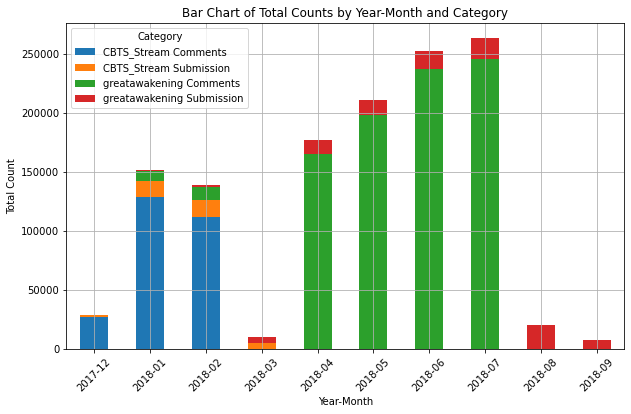

In [74]:
# Extract the year and month from the 'created_utc' column and create a new column 'YearMonth'
df_1['YearMonth'] = df_1['created_utc'].dt.to_period('M')

# Group the DataFrame by 'YearMonth' and 'Category' and calculate the count
grouped = df_1.groupby(['YearMonth', 'Category']).size().unstack(fill_value=0)

# Plot the bar chart
ax = grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Year-Month')
plt.ylabel('Total Count')
plt.title('Bar Chart of Total Counts by Year-Month and Category')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title='Category')
plt.grid()
plt.show()

## Crossover users between CBTS & Great Awakening

In [77]:
cbts_users = set(subs[subs['subreddit'] == 'CBTS_Stream']['author']).union(set(coms[coms['subreddit'] == 'CBTS_Stream']['author']))
ga_users = set(subs[subs['subreddit'] == 'greatawakening']['author']).union(set(coms[coms['subreddit'] == 'greatawakening']['author']))
crossover_users = cbts_users.intersection(ga_users)

In [78]:
len(crossover_users)

4887

In [79]:
grouped = df_1.groupby('author').size().reset_index(name='row_count')

# Sort by the count in descending order
sorted_grouped = grouped.sort_values(by='row_count', ascending=False)

# Calculate the number of users to select (top 10%)
top_10_percent = int(0.05 * len(sorted_grouped))

# Select the top 10% of users with the highest counts
top_users = sorted_grouped.head(top_10_percent)

top_users_names = set(top_users['author'])

In [80]:
len(top_users_names.intersection(crossover_users))

974

In [81]:
top_users

,author,row_count
19180,[deleted],101474
22562,digital_refugee,7392
13306,Pure_Feature,5163
31458,solanojones95,4926
31828,storm_fa_Q,4414
...,...,...
14988,Seahag14,145
19061,ZLegacy,145
19555,aleister,145
19740,andsotheydid,145
